# Restricted Space Neural Decoding for Motor Intent

Using the Physionet EEG Motor Movement/Imagery Dataset to decode motor intent from EEG signals using only 8 channels.

This code is NOT modularized or at the quality of production code. This is an exploratory notebook.

## Installs + Imports + Setup

In [ ]:
!pip install mne wget braindecode torch

In [ ]:
import mne
import wget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
import torch
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange
from braindecode.models.functions import squeeze_final_output
from braindecode.models.modules import Ensure4d, Expression
from torch.utils.data import DataLoader, TensorDataset, random_split
warnings.filterwarnings("ignore")

## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to your local data
local_data_dir = "/content/drive/My Drive/Senior Design/model dev/Datasets/mne_data/files"

# Task codes for IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST
task_codes = ["04", "08", "12"]

# Collect paths for subjects 1–79 and specific task codes
physionet_paths = []
for subject_id in range(1, 79):  # Loop through subjects 1–79
    subject_folder = f"S{str(subject_id).zfill(3)}"  # Format: S001, S002, ..., S079
    subject_path = os.path.join(local_data_dir, subject_folder)

    if os.path.isdir(subject_path):  # Check if the subject folder exists
        for filename in os.listdir(subject_path):  # Loop through files in the folder
            if filename.endswith(".edf") and filename[5:7] in task_codes:  # Match task codes
                physionet_paths.append(os.path.join(subject_path, filename))


In [ ]:
# 4, 8, 12 -- imagine open/close left/right hand
physionet_paths = [
    mne.datasets.eegbci.load_data(
        id,
        [4, 8, 12]
    )
    for id in range(1, 109)
]
physionet_paths = np.concatenate(physionet_paths)

In [ ]:
indiv_samp = [
    mne.io.read_raw_edf(
        path,
        preload=True,
        stim_channel='auto',
        verbose='WARNING',
    )
    for path in physionet_paths
]
raw_data = mne.io.concatenate_raws(indiv_samp)
events, _ = mne.events_from_annotations(raw_data)

In [ ]:
# 64 channel EEG, no EOG
eeg_channel_inds = mne.pick_types(
    raw_data.info,
    meg=False,
    eeg=True,
    stim=False,
    eog=False,
    exclude='bads',
)

In [ ]:
epoched = mne.Epochs(
    raw_data,
    events,
    dict(rest=1, left=2),
    tmin=.3,
    tmax=3.4,
    proj=False,
    picks=eeg_channel_inds,
    baseline=None,
    preload=True
)

Not setting metadata
5350 matching events found
No baseline correction applied
Using data from preloaded Raw for 5350 events and 497 original time points ...
0 bad epochs dropped


In [ ]:
X = (epoched.get_data() * 1e3).astype(np.float32)
y = (epoched.events[:, 2] - 1).astype(np.int64)

In [ ]:
# examine class balance/imbalance
unique, counts = np.unique(y, return_counts=True)
result = dict(zip(unique, counts))
print(result)

{0: 3555, 1: 1795}


## Decoding 64 Channel EEG with EEGNet

### Network Architecture

I implemented EEGNet (sort of) from scratch using the EEGNet paper and the braindecode GitHub. This really helped me understand each part of the network. Worth noting that this is EEGNetv4 from braindecode.

In [ ]:
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm=1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x):
        with torch.no_grad():
            self.weight.data = torch.renorm(
                self.weight.data, p=2, dim=0, maxnorm=self.max_norm
            )
        return super(Conv2dWithConstraint, self).forward(x)

In [ ]:
class EEGNet64Ch(nn.Module):
    def __init__(self):
        super().__init__()

        self.post_one = None
        self.post_two = None

        self.ensuredims = Ensure4d()
        self.dimshuffle = Rearrange("batch ch t 1 -> batch 1 ch t")

        self.block_one = nn.Sequential(
            nn.Conv2d(1, 8, (1, 64), stride=1, bias=False, padding=(0, 64 // 2)),
            nn.BatchNorm2d(8, momentum=0.01, affine=True, eps=1e-3),
            Conv2dWithConstraint(8, 8 * 2, (64, 1), max_norm=1, stride=1, bias=False, groups=8, padding=(0, 0)),
            nn.BatchNorm2d(8 * 2, momentum=0.01, affine=True, eps=1e-3),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4)),
            nn.Dropout(p=0.25)
        )

        self.block_two = nn.Sequential(
            nn.Conv2d(8 * 2, 8 * 2, (1, 16), stride=1, bias=False, groups=8 * 2, padding=(0, 16 // 2)),
            nn.Conv2d(8 * 2, 8 * 2, (1, 1), stride=1, padding=(0, 0), bias=False),
            nn.BatchNorm2d(8 * 2, momentum=0.01, affine=True, eps=1e-3),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8)),
            nn.Dropout(p=0.25)
        )

        self.classifying_block = nn.Sequential(
            nn.Conv2d(8 * 2, 2, (1, 15), bias=True),
            Rearrange("batch x y z -> batch x z y"),
            Expression(squeeze_final_output),
        )

    def forward(self, x):
        x = self.ensuredims(x)
        x = self.dimshuffle(x)

        x = self.block_one(x)
        self.post_one = x.clone().detach()

        x = self.block_two(x)
        self.post_two = x.clone().detach()

        x = self.classifying_block(x)
        return x


### Dataloaders

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Training Loop

In [ ]:
model = EEGNet64Ch()
print(model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)

model.to(device)

EEGNet64Ch(
  (ensuredims): Ensure4d()
  (dimshuffle): Rearrange('batch ch t 1 -> batch 1 ch t')
  (block_one): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Conv2dWithConstraint(8, 16, kernel_size=(64, 1), stride=(1, 1), groups=8, bias=False)
    (3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (6): Dropout(p=0.25, inplace=False)
  )
  (block_two): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5

EEGNet64Ch(
  (ensuredims): Ensure4d()
  (dimshuffle): Rearrange('batch ch t 1 -> batch 1 ch t')
  (block_one): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Conv2dWithConstraint(8, 16, kernel_size=(64, 1), stride=(1, 1), groups=8, bias=False)
    (3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (6): Dropout(p=0.25, inplace=False)
  )
  (block_two): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5

In [ ]:
num_epochs = 100

train_losses = []
val_losses = []

train_acc = []
val_acc = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)


    train_accuracy = correct_train / total_train
    train_loss /= total_train

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= total_val

    val_losses.append(val_loss)
    val_acc.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/100, Train Loss: 0.6939, Train Accuracy: 0.5762, Val Loss: 0.6714, Val Accuracy: 0.6664
Epoch 2/100, Train Loss: 0.6386, Train Accuracy: 0.6495, Val Loss: 0.6614, Val Accuracy: 0.6664
Epoch 3/100, Train Loss: 0.6065, Train Accuracy: 0.6701, Val Loss: 0.6501, Val Accuracy: 0.6682
Epoch 4/100, Train Loss: 0.5904, Train Accuracy: 0.6841, Val Loss: 0.6337, Val Accuracy: 0.6710
Epoch 5/100, Train Loss: 0.5674, Train Accuracy: 0.7035, Val Loss: 0.6109, Val Accuracy: 0.6841
Epoch 6/100, Train Loss: 0.5475, Train Accuracy: 0.7231, Val Loss: 0.5835, Val Accuracy: 0.7112
Epoch 7/100, Train Loss: 0.5345, Train Accuracy: 0.7437, Val Loss: 0.5539, Val Accuracy: 0.7411
Epoch 8/100, Train Loss: 0.5146, Train Accuracy: 0.7495, Val Loss: 0.5284, Val Accuracy: 0.7542
Epoch 9/100, Train Loss: 0.5009, Train Accuracy: 0.7671, Val Loss: 0.5098, Val Accuracy: 0.7645
Epoch 10/100, Train Loss: 0.4851, Train Accuracy: 0.7785, Val Loss: 0.4955, Val Accuracy: 0.7766
Epoch 11/100, Train Loss: 0.4775, Train

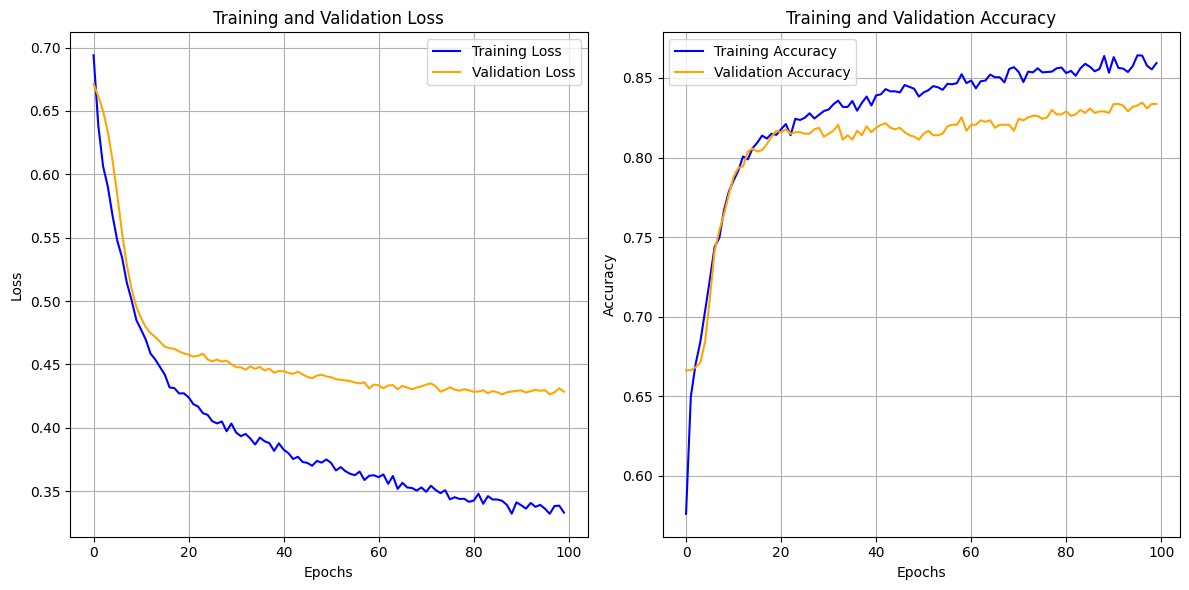

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


It's interesting to see that even with dropout, the training accuracy surpasses the validation accuracy. I'll adjust the dropout probability parameter to see how it affects this in the future.

## Decoding 8 Channel EEG with EEGNet

### Reload Data

Here, I am loading the data once more from the downloaded files and selected the 8 channels on the frontal lobe (prefrontal cortex).

In [ ]:
X = None
y = None

X_tensor = None
y_tensor = None

dataset = None
train_dataset, val_dataset = None, None

train_loader = None
val_loader = None

indiv_samp = [
    mne.io.read_raw_edf(
        path,
        preload=True,
        stim_channel='auto',
        verbose='WARNING',
    )
    for path in physionet_paths
]

for i, raw in enumerate(indiv_samp):
    if raw.info['sfreq'] != indiv_samp[0].info['sfreq']:
        indiv_samp[i] = raw.resample(indiv_samp[0].info['sfreq'])


raw_data = mne.io.concatenate_raws(indiv_samp)
indiv_samp = None
events, _ = mne.events_from_annotations(raw_data)

eeg_channel_inds = mne.pick_channels(raw_data.info['ch_names'], ['F7..',
                                                                 'Af7.',
                                                                 'Fp1.',
                                                                 'Fpz.',
                                                                 'Fp2.',
                                                                 'Af8.',
                                                                 'F8..',
                                                                 'Ft8.'])
epoched = mne.Epochs(
    raw_data,
    events,
    dict(rest=1, left=2),
    tmin=.3,
    tmax=3.4,
    proj=False,
    picks=eeg_channel_inds,
    baseline=None,
    preload=True
)

X = (epoched.get_data() * 1e3).astype(np.float32)
y = (epoched.events[:, 2] - 1).astype(np.int64)

# examine class balance/imbalance
unique, counts = np.unique(y, return_counts=True)
result = dict(zip(unique, counts))
print(result)

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
5283 matching events found
No baseline correction applied
Using data from preloaded Raw for 5283 events and 497 original time points ...
0 bad epochs dropped
{0: 3510, 1: 1773}


### Network Architecture

In [ ]:
class EEGNet8Ch(nn.Module):
    def __init__(self):
        super().__init__()

        self.post_one = None
        self.post_two = None

        self.ensuredims = Ensure4d()
        self.dimshuffle = Rearrange("batch ch t 1 -> batch 1 ch t")

        self.block_one = nn.Sequential(
            nn.Conv2d(1, 8, (1, 64), stride=1, bias=False, padding=(0, 64 // 2)),
            nn.BatchNorm2d(8, momentum=0.01, affine=True, eps=1e-3),
            Conv2dWithConstraint(8, 8 * 2, (8, 1), max_norm=1, stride=1, bias=False, groups=8, padding=(0, 0)),
            nn.BatchNorm2d(8 * 2, momentum=0.01, affine=True, eps=1e-3),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4)),
            nn.Dropout(p=0.25)
        )

        self.block_two = nn.Sequential(
            nn.Conv2d(8 * 2, 8 * 2, (1, 16), stride=1, bias=False, groups=8 * 2, padding=(0, 16 // 2)),
            nn.Conv2d(8 * 2, 8 * 2, (1, 1), stride=1, padding=(0, 0), bias=False),
            nn.BatchNorm2d(8 * 2, momentum=0.01, affine=True, eps=1e-3),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8)),
            nn.Dropout(p=0.25)
        )

        self.classifying_block = nn.Sequential(
            nn.Conv2d(8 * 2, 2, (1, 15), bias=True),
            Rearrange("batch x y z -> batch x z y"),
            Expression(squeeze_final_output),
        )

    def forward(self, x):
        x = self.ensuredims(x)
        x = self.dimshuffle(x)

        x = self.block_one(x)
        self.post_one = x.clone().detach()

        x = self.block_two(x)
        self.post_two = x.clone().detach()

        x = self.classifying_block(x)
        return x


###Dataloaders

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Training Loop

In [ ]:
model = EEGNet8Ch()
print(model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)

model.to(device)

In [ ]:
num_epochs = 100

train_losses = []
val_losses = []

train_acc = []
val_acc = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)


    train_accuracy = correct_train / total_train
    train_loss /= total_train

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= total_val

    val_losses.append(val_loss)
    val_acc.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/100, Train Loss: 0.6662, Train Accuracy: 0.5918, Val Loss: 0.6909, Val Accuracy: 0.6084
Epoch 2/100, Train Loss: 0.6370, Train Accuracy: 0.6315, Val Loss: 0.6838, Val Accuracy: 0.6495
Epoch 3/100, Train Loss: 0.6246, Train Accuracy: 0.6586, Val Loss: 0.6736, Val Accuracy: 0.6673
Epoch 4/100, Train Loss: 0.6102, Train Accuracy: 0.6808, Val Loss: 0.6588, Val Accuracy: 0.6682
Epoch 5/100, Train Loss: 0.6065, Train Accuracy: 0.6808, Val Loss: 0.6436, Val Accuracy: 0.6785
Epoch 6/100, Train Loss: 0.5942, Train Accuracy: 0.6965, Val Loss: 0.6253, Val Accuracy: 0.6850
Epoch 7/100, Train Loss: 0.5872, Train Accuracy: 0.6965, Val Loss: 0.6099, Val Accuracy: 0.6879
Epoch 8/100, Train Loss: 0.5782, Train Accuracy: 0.7082, Val Loss: 0.5962, Val Accuracy: 0.6972
Epoch 9/100, Train Loss: 0.5719, Train Accuracy: 0.7098, Val Loss: 0.5877, Val Accuracy: 0.7019
Epoch 10/100, Train Loss: 0.5681, Train Accuracy: 0.7159, Val Loss: 0.5801, Val Accuracy: 0.7103
Epoch 11/100, Train Loss: 0.5606, Train

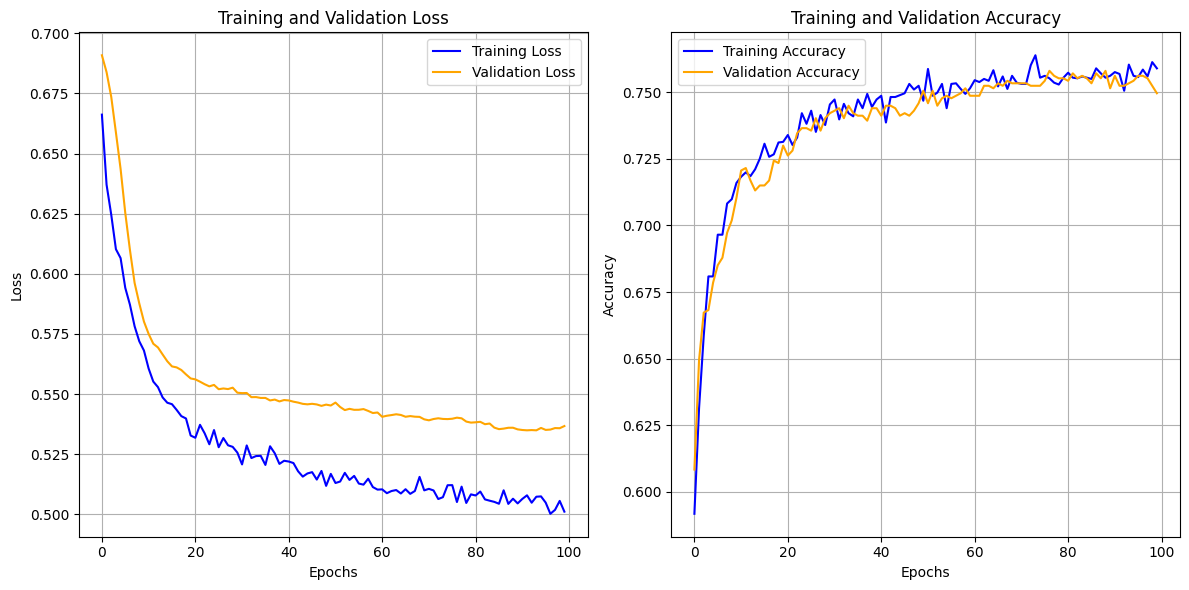

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


I'm almost impressed as using only a fourth of the channels yields only a 10 point decrease in accuracy. I wouldn't consider ~75 percent validation accuracy the ideal goal, this proves to me that there is something to learn and more complex architectures may be able to perform better on this restricted problem.

## Decoding 8 Channel EEG Using the Short-Time Fourier Transform and an LSTM Architecture

### Network Architecture

I wanted to leverage an LSTM based architecture to take advantage of the possibility of learning features across time. I also wanted to be more intentional with feature extraction. Thus, I'm using an STFT to get some features and plug that into an LSTM.

To reshape the output of the STFT for input to the LSTM, I eventually get it in time_bin X channel * frequency_bin. Such that the time_bin is the sequence.

I then thought that 8 channels * frequency_bin is a lot of features. So I decided to do a depthwise 2D convolution to merge them into 1 channel. Although, given EEG is already such an averaged signal, I'm not sure if this was the best idea.

There's a ways to go with this architecture but I do think it's promising.

In [ ]:
class STFT_LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(16, 16, (8, 1))

        self.lstm = nn.LSTM(input_size=33,
                            hidden_size=32,
                            num_layers=1,
                            dropout=0.25,
                            batch_first=True)

        self.fc = nn.Linear(32, 2)


    def forward(self, x):
        b = x.shape[0]
        x = x.reshape(x.shape[0]*x.shape[1], 497)
        x = torch.stft(input=x,
                       n_fft=64,
                       win_length=64,
                       hop_length=32,
                       return_complex=False,
                       center=True)

        x = x[..., 0].reshape(b, 8, 33, 16).permute(0, 3, 1, 2)

        x = self.conv(x).squeeze(dim=2)

        x, (h, c) = self.lstm(x)

        x = x[:, -1, :]
        x = self.fc(x)

        return x

In [ ]:
data = torch.randn(64, 8, 497)

model = STFT_LSTM()
output = model(data)
output.shape

torch.Size([64, 2])

### Training Loop

In [ ]:
model = STFT_LSTM()
print(model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-3)

model.to(device)

STFT_LSTM(
  (conv): Conv2d(16, 16, kernel_size=(8, 1), stride=(1, 1))
  (lstm): LSTM(33, 32, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


STFT_LSTM(
  (conv): Conv2d(16, 16, kernel_size=(8, 1), stride=(1, 1))
  (lstm): LSTM(33, 32, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
num_epochs = 500

train_losses = []
val_losses = []

train_acc = []
val_acc = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)


    train_accuracy = correct_train / total_train
    train_loss /= total_train

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= total_val

    val_losses.append(val_loss)
    val_acc.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/500, Train Loss: 0.6916, Train Accuracy: 0.5663, Val Loss: 0.6905, Val Accuracy: 0.5960
Epoch 2/500, Train Loss: 0.6898, Train Accuracy: 0.6098, Val Loss: 0.6886, Val Accuracy: 0.6263
Epoch 3/500, Train Loss: 0.6880, Train Accuracy: 0.6335, Val Loss: 0.6867, Val Accuracy: 0.6500
Epoch 4/500, Train Loss: 0.6863, Train Accuracy: 0.6493, Val Loss: 0.6848, Val Accuracy: 0.6585
Epoch 5/500, Train Loss: 0.6845, Train Accuracy: 0.6538, Val Loss: 0.6829, Val Accuracy: 0.6623
Epoch 6/500, Train Loss: 0.6828, Train Accuracy: 0.6564, Val Loss: 0.6811, Val Accuracy: 0.6641
Epoch 7/500, Train Loss: 0.6811, Train Accuracy: 0.6593, Val Loss: 0.6792, Val Accuracy: 0.6660
Epoch 8/500, Train Loss: 0.6792, Train Accuracy: 0.6593, Val Loss: 0.6770, Val Accuracy: 0.6689
Epoch 9/500, Train Loss: 0.6771, Train Accuracy: 0.6602, Val Loss: 0.6748, Val Accuracy: 0.6708
Epoch 10/500, Train Loss: 0.6749, Train Accuracy: 0.6607, Val Loss: 0.6725, Val Accuracy: 0.6746
Epoch 11/500, Train Loss: 0.6727, Train

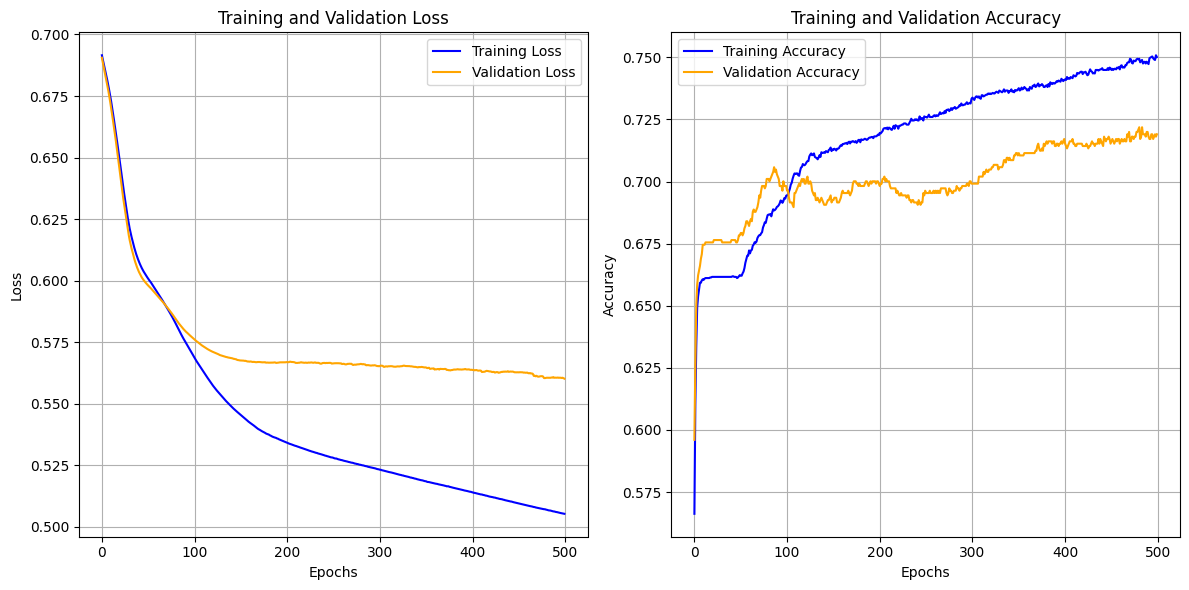

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


I have a hunch that if I were to let this go for 1000 epochs, the model would completely overfit on the training data. hm...

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 8426
Trainable parameters: 8426


## Decoding 8 Channel Data with EEGNet-LSTM

Here, I'm using an EEGNet-based architecture that is more closely related to the EEGNet paper (not the braindecode EEGNet v4). I used the CNN portion to learn features, I then reshaped the data to plug into an LSTM. I thought this would also yield interesting results.


In [ ]:
class EEGNetModel(nn.Module):
    def __init__(self):
        super(EEGNetModel, self).__init__()
        # Calculating FC input features
        linear_size = (497//(8*16))*32

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, (1, 32), padding='same', bias=False),
            nn.BatchNorm2d(16),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 2 * 16, (8, 1), groups=16, bias=False), # Depthwise Conv
            nn.BatchNorm2d(2 * 16),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.25)
        )

        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=32,
                            num_layers=1,
                            batch_first=True)

        self.fc = nn.Linear(32, 2)
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = self.block1(x)
        x = self.block2(x)
        x = x.squeeze(dim=2)
        x = x.permute(0, 2, 1)
        x, (h, c) = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x


In [ ]:
samp_data = torch.randn(64, 8, 497)
model = EEGNetModel()
output = model(samp_data)
output.shape

torch.Size([64, 2])

In [ ]:
model = EEGNetModel()
print(model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-5)

model.to(device)

EEGNetModel(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 32), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(8, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


EEGNetModel(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 32), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(8, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
num_epochs = 200

train_losses = []
val_losses = []

train_acc = []
val_acc = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)


    train_accuracy = correct_train / total_train
    train_loss /= total_train

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= total_val

    val_losses.append(val_loss)
    val_acc.append(val_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/200, Train Loss: 0.6471, Train Accuracy: 0.6550, Val Loss: 0.6176, Val Accuracy: 0.6604
Epoch 2/200, Train Loss: 0.6146, Train Accuracy: 0.6623, Val Loss: 0.6044, Val Accuracy: 0.6594
Epoch 3/200, Train Loss: 0.6058, Train Accuracy: 0.6664, Val Loss: 0.6001, Val Accuracy: 0.6613
Epoch 4/200, Train Loss: 0.6052, Train Accuracy: 0.6744, Val Loss: 0.6010, Val Accuracy: 0.6623
Epoch 5/200, Train Loss: 0.6000, Train Accuracy: 0.6682, Val Loss: 0.6084, Val Accuracy: 0.6660
Epoch 6/200, Train Loss: 0.6012, Train Accuracy: 0.6789, Val Loss: 0.6080, Val Accuracy: 0.6623
Epoch 7/200, Train Loss: 0.5927, Train Accuracy: 0.6756, Val Loss: 0.6050, Val Accuracy: 0.6641
Epoch 8/200, Train Loss: 0.5904, Train Accuracy: 0.6865, Val Loss: 0.6007, Val Accuracy: 0.6840
Epoch 9/200, Train Loss: 0.5869, Train Accuracy: 0.6822, Val Loss: 0.6068, Val Accuracy: 0.6727
Epoch 10/200, Train Loss: 0.5792, Train Accuracy: 0.6926, Val Loss: 0.6074, Val Accuracy: 0.6812
Epoch 11/200, Train Loss: 0.5777, Train

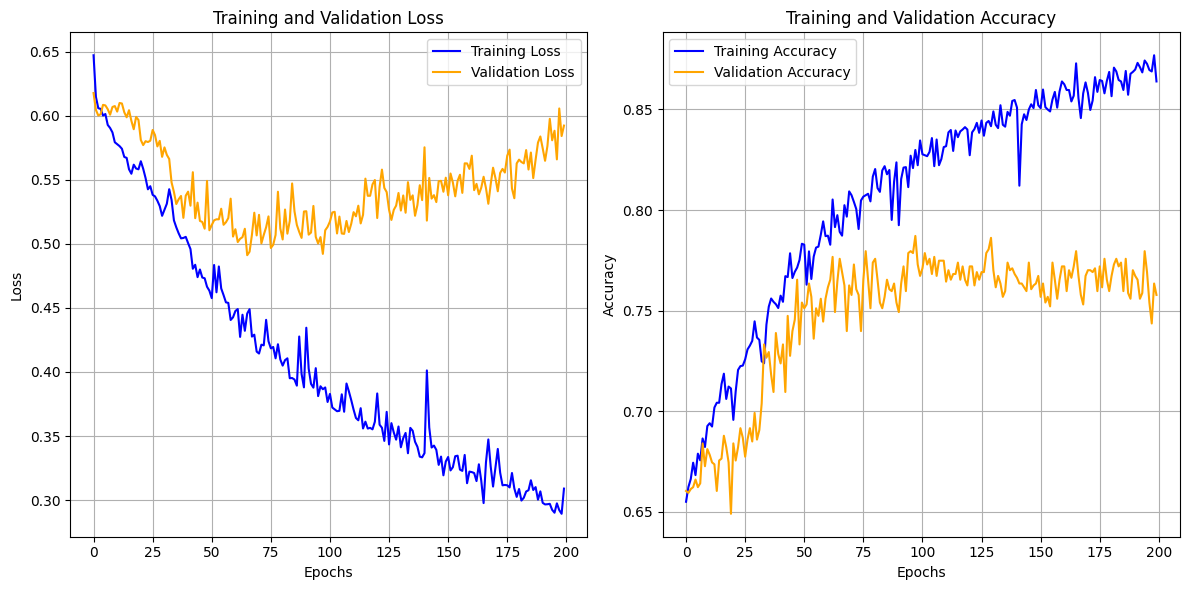

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Alas, it clearly has overfit. hm....